simple tutorial for the binary Pima Indians Diabetes Database
-Number of Instances: 768

-Number of Attributes: 8 plus class 

-For Each Attribute: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

-Missing Attribute Values: Yes

-Class Distribution: (class value 1 is interpreted as "tested positive for
   diabetes")

   Class Value  Number of instances
   0            500
   1            268

### Packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import ParameterGrid 

import time

#from xgboost.sklearn import XGBRegressor
#from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

### Data

In [2]:
path = "c:\\datasets\\pima-indians-diabetes.csv"
columns = ['Pregnancies','PlasmaGlucoseConc','DBloodPressure','TricepsSkinFoldThick',
           'TwoHoursSerumInsulin','BMI','DiabetesPedigreeFunction','Age','target']
   # Number of times pregnant
   # Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   # Diastolic blood pressure (mm Hg)
   # Triceps skin fold thickness (mm)
   # 2-Hour serum insulin (mu U/ml)
   # Body mass index (weight in kg/(height in m)^2)
   # Diabetes pedigree function
   # Age (years)
   # Class variable (0 or 1)


In [3]:
diabetes = pd.read_csv(path,header=None, names=columns)

## Exploratory Analyisis and Data Preparation and Manipulation

In [4]:
print(diabetes.head(),"\n",diabetes.shape)

   Pregnancies  PlasmaGlucoseConc  DBloodPressure  TricepsSkinFoldThick  \
0            6                148              72                    35   
1            1                 85              66                    29   
2            8                183              64                     0   
3            1                 89              66                    23   
4            0                137              40                    35   

   TwoHoursSerumInsulin   BMI  DiabetesPedigreeFunction  Age  target  
0                     0  33.6                     0.627   50       1  
1                     0  26.6                     0.351   31       0  
2                     0  23.3                     0.672   32       1  
3                    94  28.1                     0.167   21       0  
4                   168  43.1                     2.288   33       1   
 (768, 9)


In [5]:
missing_val_count_by_column = (diabetes.isnull().sum())
print("overall ", len(missing_val_count_by_column[missing_val_count_by_column > 0]) , 
      "variables with missing values" , "\nin details:","\n" , 
      missing_val_count_by_column[missing_val_count_by_column > 0])

overall  0 variables with missing values 
in details: 
 Series([], dtype: int64)


In [6]:
diabetes.describe(include='all').T

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
PlasmaGlucoseConc         768.0  120.894531   31.972618   0.000  99.00000   
DBloodPressure            768.0   69.105469   19.355807   0.000  62.00000   
TricepsSkinFoldThick      768.0   20.536458   15.952218   0.000   0.00000   
TwoHoursSerumInsulin      768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
target                    768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
PlasmaGlucoseConc         117.0000  140.25000  199.00  
DBloodPressure             72.0000   80.00000  122.00  
TricepsSkinFoldThick       23.0000   32.00000   99.00  
TwoHoursSerumInsulin       30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
target                      0.0000    1.00000    1.00

In [7]:
print(diabetes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   PlasmaGlucoseConc         768 non-null    int64  
 2   DBloodPressure            768 non-null    int64  
 3   TricepsSkinFoldThick      768 non-null    int64  
 4   TwoHoursSerumInsulin      768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   target                    768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


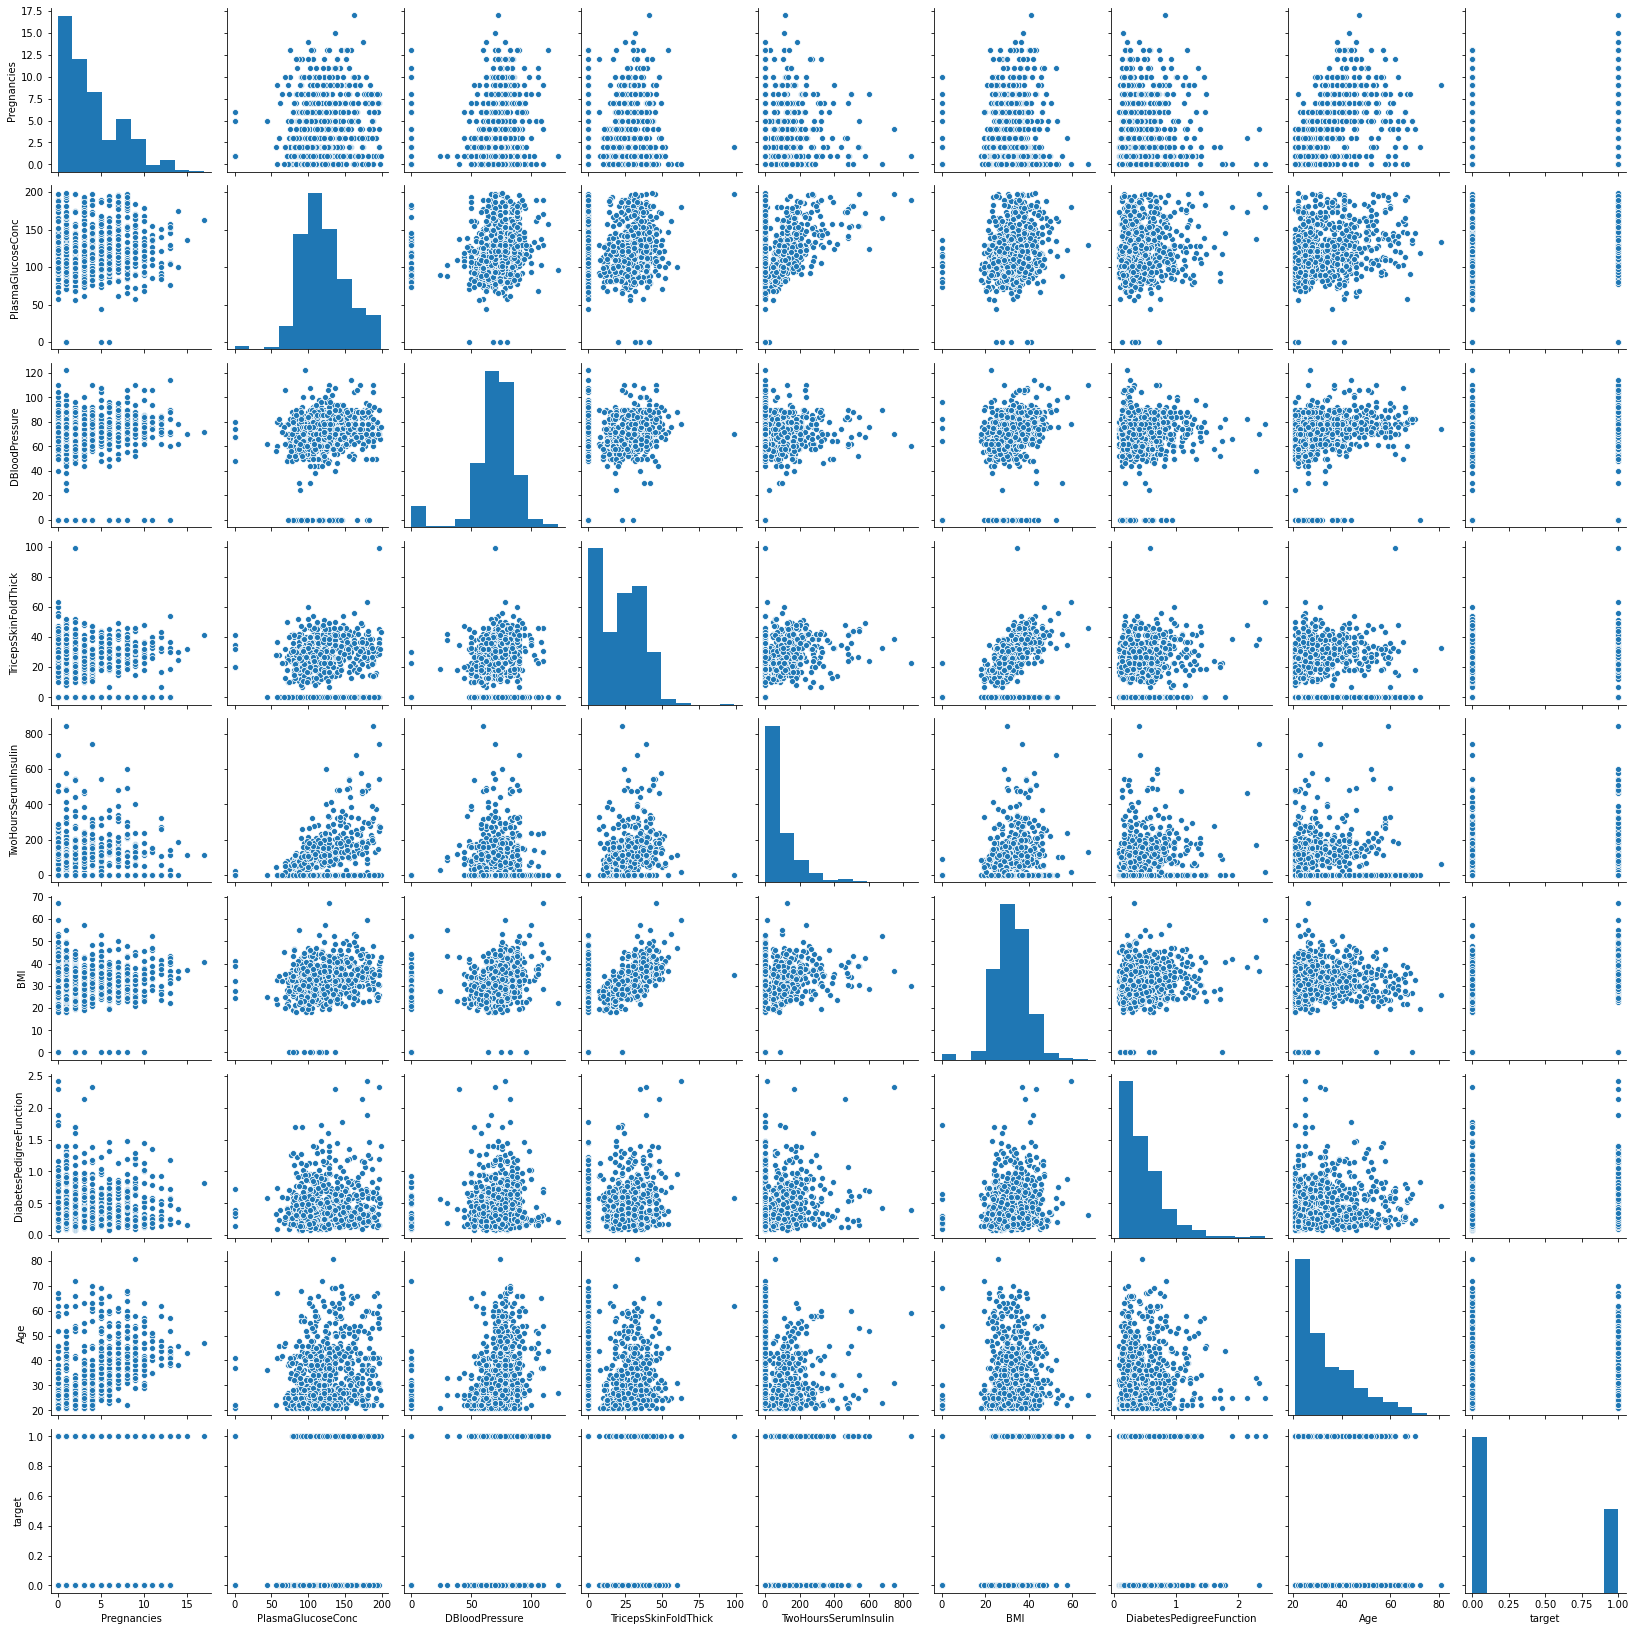

In [8]:
num_columns= [*diabetes.select_dtypes(['int64', 'float64']).columns]

sns.pairplot(diabetes[num_columns])
plt.show()

In [9]:
"""Calculate the ratio how balanced is this sample"""

def pc_func(x):
    #2 decimal percentage format 
    return '{:.2%}'.format(x)
print("\nratio:",pc_func(diabetes[diabetes.target==1].target.count()/diabetes.target.count()))


ratio: 34.90%


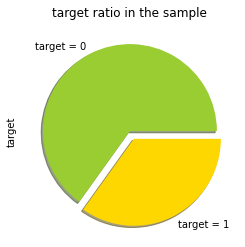

In [10]:
colors = ['yellowgreen', 'gold']
explode = (0, 0.1)
labels = 'target = 0','target = 1' 
values = diabetes['target'].value_counts()
values.plot(kind='pie',explode = explode, title='target ratio in the sample',colors=colors,shadow=True, labels = labels)
plt.show()

In [11]:
#split the tale into feature matrix and target vector
y = diabetes.loc[:,['target']]
X = diabetes.drop(columns=['target'])
columns = X.columns

## Low variance features dropping

In [12]:
X.var().sort_values()

DiabetesPedigreeFunction        0.109779
Pregnancies                    11.354056
BMI                            62.159984
Age                           138.303046
TricepsSkinFoldThick          254.473245
DBloodPressure                374.647271
PlasmaGlucoseConc            1022.248314
TwoHoursSerumInsulin        13281.180078
dtype: float64

In [13]:
print('before shape:',X.shape)
selector = VarianceThreshold(threshold=.001)
#selector = VarianceThreshold(threshold=.01)
#selector = VarianceThreshold()
selector.fit(X)
X2 = X[X.columns[selector.get_support(indices=True)]]
X2c=X2.columns.values.tolist()
X = X[X2c]
print('after shape:',X.shape)

before shape: (768, 8)
after shape: (768, 8)


### Correlations

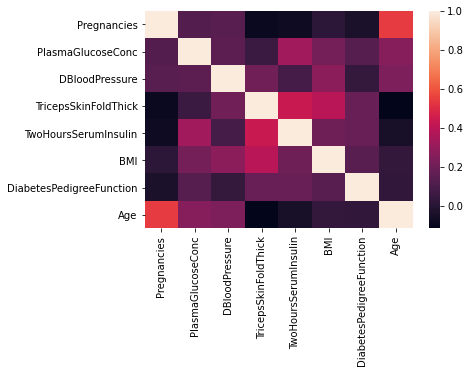

In [14]:
#CORRELATION HEATMAP
import seaborn as sns
sns.heatmap(X.corr())
plt.show()

In [15]:
#CORRELATION MATRIX with values
corr = X.corr()
corr.style.background_gradient()

looks fine, not very strong correlations

### Dropping Strongly Correlated Variables

In [16]:
#I put this step to the beginning to filter the strongly correlated ones
#so the RFE may take shorter
#drop highly correlated variables
# Create correlation matrix (absolute values make things easier)
import time
start_time = time.time()
corr = X.corr()
corr_matrix = corr.abs()

# Select upper triangle of correlation matrix (just one direction is enough)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features 
X2 = X.drop(to_drop, axis=1)
#New feature list
X2c=X2.columns.values.tolist()

def d2_func(x):
    #2 decimal percentage format 
    return '{:.2f}'.format(x)
print("This run took", d2_func(time.time() - start_time), " seconds to run")
print("New list:",X2c,"\nDrop list:",to_drop)
print(len(to_drop),"features were dropped","\n",len(X2c),"features remained")

This run took 0.12  seconds to run
New list: ['Pregnancies', 'PlasmaGlucoseConc', 'DBloodPressure', 'TricepsSkinFoldThick', 'TwoHoursSerumInsulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'] 
Drop list: []
0 features were dropped 
 8 features remained


### Recursive Feature Elimination

In [17]:
# Recursive Feature Elimination : it takes for a while to run for big data
# here We keep all of the features 10>8
# notes: ravel is not necessary it just flatten the array, can use other tech, not only log reg if you want
from sklearn.feature_selection import RFE

start_time = time.time()

Xc=X2.columns.values.tolist()
yc=['target']
#define solver to prevent warnings
#logreg = LogisticRegression(solver = 'liblinear')
logreg = LogisticRegression(solver = 'sag')
rfe = RFE(logreg, 10)
rfe = rfe.fit(X2, y.values.ravel())
print("This run took", time.time() - start_time, "to run")
print(Xc)
print(rfe.support_)
print(rfe.ranking_)

This run took 0.11401844024658203 to run
['Pregnancies', 'PlasmaGlucoseConc', 'DBloodPressure', 'TricepsSkinFoldThick', 'TwoHoursSerumInsulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
[ True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1]


C:\Users\Gergo\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [18]:
#KEEP THE SELECTED FEATURES ONLY: newXd
#Value list to numpy array to process, then change back to list, after the filter
Xcnp = np.array(Xc)
my_filter = np.array(rfe.support_, dtype=bool)
new_Xc = Xcnp[my_filter].tolist()
newX = X[new_Xc]

<Figure size 432x288 with 0 Axes>

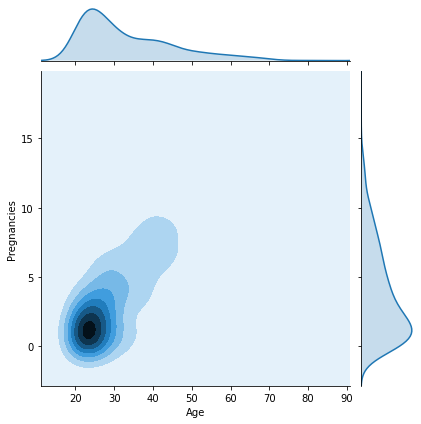

In [19]:
#nice visualization to check correlated variables
#flt = (newXd.i_age>18) & (newXd.i_ele_consumption_eac<10000)& (newXd.i_ele_consumption_eac>-1000)
#newXd_G=newXd[flt]
plt.clf()
gt = sns.jointplot(x='Age',y='Pregnancies',data =newX, kind= 'kde' )
plt.show()

### P value analysis

In [20]:
#P value analysis - I use this to get the p values and then drop those where the p value is too big
#2 or 3 iteration will be enough to drop the big p values
import statsmodels.api as sm
logit_model=sm.Logit(y,newX)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.608498
         Iterations 5
                             Results: Logit
Model:                 Logit              Pseudo R-squared:   0.059     
Dependent Variable:    target             AIC:                950.6528  
Date:                  2020-07-29 21:35   BIC:                987.8031  
No. Observations:      768                Log-Likelihood:     -467.33   
Df Model:              7                  LL-Null:            -496.74   
Df Residuals:          760                LLR p-value:        2.5825e-10
Converged:             1.0000             Scale:              1.0000    
No. Iterations:        5.0000                                           
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Pregnancies               0.1284   0.0286  4.4843 0

In [21]:
#2 dicitionaries: coef value and pvalue
# coefficients just in case, I won't use them
coef = []
coefficients = result.params
for v in new_Xc:
    coef.append(coefficients[v])
col_dict = dict(zip(new_Xc, coef))

#Drop where the p value is too big
pvalue = result.pvalues
fil = result.pvalues <=0.05
newXc_np = np.array(new_Xc)
final_featuresX = newXc_np[fil.tolist()].tolist()
final_featuresX

finalX=X[final_featuresX]
print("remaining feature number:" ,len(final_featuresX))

remaining feature number: 3


#### It's interesting - maybe for non linear models we still can use them, or maybe we should transform the original variables

In [22]:
#2nd run will be hopefully good but it may be redundant
logit_model2=sm.Logit(y,finalX)
result=logit_model2.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.613118
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.052     
Dependent Variable: target           AIC:              947.7495  
Date:               2020-07-29 21:35 BIC:              961.6808  
No. Observations:   768              Log-Likelihood:   -470.87   
Df Model:           2                LL-Null:          -496.74   
Df Residuals:       765              LLR p-value:      5.8346e-12
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Pregnancies        0.0951   0.0238  3.9956 0.0001  0.0484  0.1417
PlasmaGlucoseConc  0.0122   0.0021  5.8041 0.0000  0.0081  0.0163


### VIF calculation (Variance Inflation Factor)

In [23]:
#Multicolinearity is hard to detect because it emerges when three or more variables, 
#which are highly correlated, are included within a model. To make matters worst multicolinearity can emerge 
#even when isolated pairs of variables are not colinear.
#So the correlation matrix above was not enough

from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    low_VIF = X.columns[variables]
    return low_VIF


low_VIF = calculate_vif_(finalX, thresh=5.0)

dropping 'DBloodPressure' at index: 2
Remaining variables:
Index(['Pregnancies', 'PlasmaGlucoseConc'], dtype='object')


#### ok, so because of the collinearity we dropped another one. 1 remaining: LOL

In [24]:
finalX_VIF = finalX[low_VIF]
final_featuresX = low_VIF.tolist()
final_featuresX

['Pregnancies', 'PlasmaGlucoseConc']

## START THE SKLEARN LOGISTIC MODEL

In [45]:
#again I use ravel() because this is what the model expect - works without it, but sends warning
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(finalX_VIF, y.values.ravel(), test_size=0.3, random_state=0)
logreg = LogisticRegression(solver = 'liblinear')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.74


In [46]:
#features & coefficients & target list (as string)
target_names = []
for n in logreg.classes_.tolist(): 
    target_names.append(str(n))
print('target names:',target_names)
logreg_features = final_featuresX
coef = logreg.coef_[0].tolist()
coef_dict = dict(zip(final_featuresX, coef))
#interception
coef_dict["interception"] = logreg.intercept_[0].tolist()
print('\ncoefficients:',coef_dict)

target names: ['0', '1']

coefficients: {'Pregnancies': 0.08365023407060704, 'PlasmaGlucoseConc': 0.02960076115082091, 'interception': -4.555771490552604}


### Evaluation

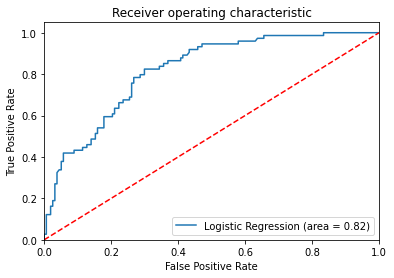

In [47]:
#ROC CURVE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### Parameter Tuning

This run took 0.1310117244720459 to run


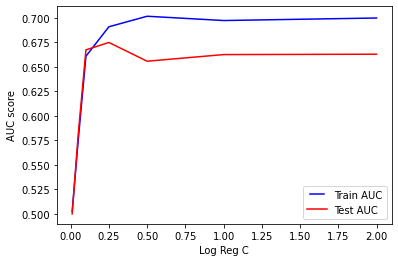

In [28]:
#check how the C value changes the AUC
#C is our regularization parameter: C = 1/λ.
# λ controls the trade-off between allowing the model to increase 
# its complexity as much as it wants with trying to keep it simple. 
# For example, if λ is very low or 0, the model will have enough power to increase it's complexity (overfit)
# by assigning big values to the weights for each parameter. 
# If, in the other hand, we increase the value of λ, the model will tend to underfit, as the model will become too simple
start_time = time.time()

C = [2, 1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for c in C:
   model = LogisticRegression(C=c, solver = 'liblinear')
   model.fit(X_train, y_train)
   train_pred = model.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = model.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
    
print("This run took", time.time() - start_time, "to run")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(C, train_results, 'b', label='Train AUC')
line2, = plt.plot(C, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Log Reg C')
plt.show()

<div class="alert alert-block alert-info">
 C evaluation: train and test are very close till 0.25 and it can be the new choice
 <br>AUC = 0.675
</div>

In [42]:
logreg = LogisticRegression(solver = 'liblinear', C=0.25)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.76


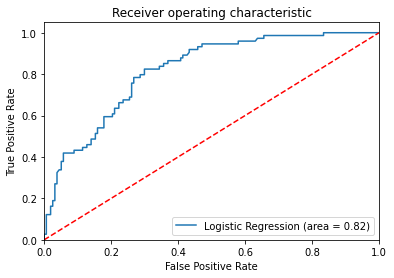

0.8177397142365295


In [48]:
#ROC CURVE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
logit_roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
print(logit_roc_auc)

This run took 0.08500170707702637 to run


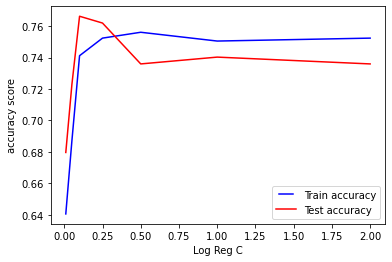

In [32]:
#check how the C value changes the Accuracy
#C is our regularization parameter: C = 1/λ.
# λ controls the trade-off between allowing the model to increase 
# its complexity as much as it wants with trying to keep it simple. 
# For example, if λ is very low or 0, the model will have enough power to increase it's complexity (overfit)
# by assigning big values to the weights for each parameter. 
# If, in the other hand, we increase the value of λ, the model will tend to underfit, as the model will become too simple
start_time = time.time()

C = [2, 1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for c in C:
   model = LogisticRegression(C=c, solver = 'liblinear')
   model.fit(X_train, y_train)
   score = model.score(X_train, y_train)
   train_results.append(score)
   score = model.score(X_test, y_test)
   test_results.append(score)
    
print("This run took", time.time() - start_time, "to run")
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(C, train_results, 'b', label='Train accuracy')
line2, = plt.plot(C, test_results, 'r', label='Test accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('accuracy score')
plt.xlabel('Log Reg C')
plt.show()

0.25 seems a logical choice, so no need to change

### with the c parameter manipulation I managed to improve the Gini and accuracy

In [34]:
#without crossvalidation

grid = {"C": [2, 1, 0.5, 0.25, 0.1, 0.05],
    "dual": [False],
    "max_iter": [80, 100,110,120,130,140],
    "random_state":[1971]} 

lrc = LogisticRegression()
#from pprint import pprint 
#pprint(list(ParameterGrid(grid)))

In [35]:
# Maximisew the AUC

test_scores = [] 
# loop through the parameter grid, set hyperparameters, save the scores 
for g in ParameterGrid(grid): 
    lrc.set_params(**g)  # ** is "unpacking" the dictionary 
    lrc.fit(X_train, y_train)
    yg_pred = lrc.predict_proba(X_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yg_pred)
    roc_aucg = auc(false_positive_rate, true_positive_rate)
    test_scores.append(roc_aucg) # find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores) 
print(test_scores[best_idx]) 
print(ParameterGrid(grid)[best_idx]) 

0.8167068342227578
{'random_state': 1971, 'max_iter': 80, 'dual': False, 'C': 0.05}


In [49]:
logreg2 = LogisticRegression(C=0.05,max_iter = 80,random_state=1971 , dual=False)
logreg2.fit(X_train, y_train)
y_pred = logreg2.predict(X_test)
yg_pred = logreg2.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yg_pred)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg2.score(X_test, y_test)))
print('AUC on test set: {:.2f}'.format(auc(false_positive_rate, true_positive_rate)))

Accuracy of logistic regression classifier on test set: 0.73
AUC on test set: 0.82


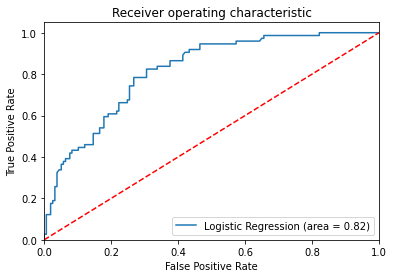

0.8167068342227578


In [50]:
#ROC CURVE
logit_roc_auc = roc_auc_score(y_test, logreg2.predict_proba(X_test)[:,1])
fpr, tpr, thresholds = roc_curve(y_test, logreg2.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
print(logit_roc_auc)

## SAVING MODELS

In [29]:
with open('logreg1.pickle', 'wb') as handle:
    pickle.dump(logreg, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# now we use the saved modell, so no need to rerun everything
#with open('logreg1.pickle', 'rb') as handle:
#    logreg = pickle.load(handle)

## GRADIENT BOOSTING

let's use the variables without really filtering out : newX, new_Xc

In [51]:
X_train, X_test, y_train, y_test = train_test_split(newX, y.values.ravel(), test_size=0.4, random_state=42)
#Crossvalidation and parameter tuning in the same time - can be used the whole Xd and y
GBmodel = GradientBoostingClassifier(random_state=2020)
GBmodel.fit(X_train, y_train)
# predic calssifies, predict_proba gives probabilities
yg_pred = GBmodel.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yg_pred)
roc_aucg = auc(false_positive_rate, true_positive_rate)
print(roc_aucg)
print(roc_auc_score(y_test, GBmodel.predict_proba(X_test)[:,1]))

0.8239101465829048
0.8239101465829048


#### huge leap compared to the logistic regression

## hyperparameters
- learning_rate = This determines the impact of each tree on the final outcome, lower values are generally preferred as they make the model robust
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- subsample = The fraction of observations to be selected for each tree

In [52]:
#without crossvalidation

grid = {    #"loss":["deviance"],
    "learning_rate": [0.1,0.25,1],
    "min_samples_split": [0.1, 0.3, 0.5],
    "min_samples_leaf": [0.1, 0.3, 0.5],
    "max_depth":[2,3,4,5],
    "max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse"],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators":[4, 8, 16, 32, 50, 100, 150],
    "random_state":[1971]} 

gbc = GradientBoostingClassifier()
#from pprint import pprint 
#pprint(list(ParameterGrid(grid)))

### optimum by accuracy

In [40]:
test_scores = [] 
# loop through the parameter grid, set hyperparameters, save the scores 
for g in ParameterGrid(grid): 
    gbc.set_params(**g)  # ** is "unpacking" the dictionary 
    gbc.fit(X_train, y_train)
    test_scores.append(gbc.score(X_test, y_test)) # find best hyperparameters from the test score and print 
best_idx = np.argmax(test_scores) 
print(test_scores[best_idx]) 
print(ParameterGrid(grid)[best_idx]) 

0.7954545454545454
{'subsample': 0.8, 'random_state': 1971, 'n_estimators': 16, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_features': 'log2', 'max_depth': 2, 'learning_rate': 0.25}


### optimum by gini

In [41]:
# optimum by gini
test_scores = [] 
# loop through the parameter grid, set hyperparameters, save the scores 
for g in ParameterGrid(grid): 
    gbc.set_params(**g)  # ** is "unpacking" the dictionary 
    gbc.fit(X_train, y_train)
    yg_pred = gbc.predict_proba(X_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yg_pred)
    roc_aucg = auc(false_positive_rate, true_positive_rate)
    test_scores.append(roc_aucg) # find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores) 
print(test_scores[best_idx]) 
print(ParameterGrid(grid)[best_idx]) 

0.845017133066819
{'subsample': 1.0, 'random_state': 1971, 'n_estimators': 8, 'min_samples_split': 0.1, 'min_samples_leaf': 0.1, 'max_features': 'log2', 'max_depth': 4, 'learning_rate': 0.25}


### THE CHOSEN ONE:

In [53]:
GBmodel3 = GradientBoostingClassifier(max_depth=4, n_estimators=8, learning_rate=0.25, subsample = 1.0, 
                                      random_state=1971,max_features='log2', min_samples_split=0.1, 
                                      min_samples_leaf=0.1 )
GBmodel3.fit(X_train, y_train)
yg_pred3 = GBmodel3.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yg_pred3)
roc_aucg3 = auc(false_positive_rate, true_positive_rate)
print('ROC_AUC:',roc_aucg3, '\nAccuracy:',GBmodel3.score(X_test, y_test))

ROC_AUC: 0.845017133066819 
Accuracy: 0.7857142857142857


In [54]:
GBmodel4 = GradientBoostingClassifier(max_depth=2, n_estimators=16, learning_rate=0.25, subsample = 0.8, 
                                      random_state=1971,max_features='log2', min_samples_split=0.1, 
                                      min_samples_leaf=0.1 )
GBmodel4.fit(X_train, y_train)
yg_pred4 = GBmodel4.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yg_pred4)
roc_aucg4 = auc(false_positive_rate, true_positive_rate)
print('ROC_AUC:',roc_aucg4, '\nAccuracy:',GBmodel4.score(X_test, y_test))

ROC_AUC: 0.8373310489244241 
Accuracy: 0.7954545454545454


## Random Forrest

In [58]:
# a basic model with default settings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# try the followings: Xd2_n (Corr0.9 and Var on norm)0.544 , newXd (after RFE) 0.543, finalX (P_value) 0.548, finalX2 (VIF) 0.533

X_train, X_test, y_train, y_test = train_test_split(newX, y.values.ravel(), test_size=0.3, random_state=1971)
#Crossvalidation and parameter tuning in the same time - can be used the whole Xd and y
RFmodel = RandomForestClassifier(random_state=2019)
RFmodel.fit(X_train, y_train)
yg_pred = RFmodel.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yg_pred)
roc_aucg = auc(false_positive_rate, true_positive_rate)
roc_aucg

0.8129111148591668

## hyperparameters
- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node

In [59]:
#without crossvalidation
from sklearn.model_selection import ParameterGrid 
grid = { 
    "n_estimators": [50,100,200,300,400,500],
    "max_features": ['auto'],
    "max_depth": [2,3,6,9,12],
    "min_samples_split":[8, 12, 16, 20],
    "min_samples_leaf":[8,15,20],
    "random_state":[1971]}

rfc = RandomForestClassifier()
#from pprint import pprint 
#pprint(list(ParameterGrid(grid)))

In [60]:
test_scores = [] 
# loop through the parameter grid, set hyperparameters, save the scores 
for g in ParameterGrid(grid): 
    rfc.set_params(**g)  # ** is "unpacking" the dictionary 
    rfc.fit(X_train, y_train)
    yg_pred = rfc.predict_proba(X_test)[:,1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yg_pred)
    roc_aucg = auc(false_positive_rate, true_positive_rate)
    test_scores.append(roc_aucg) # find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores) 
print(test_scores[best_idx]) 
print(ParameterGrid(grid)[best_idx]) 



0.8245066621689998
{'random_state': 1971, 'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 9}
0.8245066621689998 {'random_state': 1971, 'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 9}


In [61]:
test_scores = [] 
for g in ParameterGrid(grid):
    gbc.set_params(**g)  # ** is "unpacking" the dictionary
    gbc.fit(X_train, y_train)
    test_scores.append(gbc.score(X_test, y_test))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

0.7748917748917749 {'random_state': 1971, 'n_estimators': 50, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'auto', 'max_depth': 3}


### THE CHOSEN ONE:

In [62]:
RFmodel3 = RandomForestClassifier(max_depth=9, n_estimators=100, max_features='auto', 
                                      random_state=1971, min_samples_split=20, 
                                      min_samples_leaf=8 )
RFmodel3.fit(X_train, y_train)
yg_pred3 = RFmodel3.predict_proba(X_test)[:,1]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, yg_pred3)
roc_aucg3 = auc(false_positive_rate, true_positive_rate)
print('ROC_AUC:',roc_aucg3, '\nAccuracy:',RFmodel3.score(X_test, y_test))

ROC_AUC: 0.8245066621689998 
Accuracy: 0.7662337662337663


## Gradient Boosting Was the best